In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import sys
import copy
from typing import (
    Dict, 
    List,
    Any
)

import mlflow
from datetime import datetime


import numpy as np
import pandas as pd

from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

from joblib import load, dump

import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils.metrics import Metrics
from utils.modelling_tools import (
    search_hyper_params_and_log, 
    update_solver_by_penalty, 
    evaluate_model
)
from utils.metrics_by_quantile import MetricsByQuantile

In [8]:
RUN_NAME: str = '02-LogRegression-hyperparams_tunning'

In [9]:
PROJECT_PATH: str = os.path.join(os.getcwd(), '..')
DATA_PATH: str = os.path.join(PROJECT_PATH, 'data')
OPT_BIN_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'optbinners')
MODELS_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'models')

In [10]:
TRAIN_FROM: datetime.date = pd.to_datetime('2021-12-01').date()
TRAIN_TO: datetime.date = pd.to_datetime('2022-01-01').date()

VAL_FROM: datetime.date = pd.to_datetime('2022-01-01').date()
VAL_TO: datetime.date = pd.to_datetime('2022-05-01').date()

TEST_FROM: datetime.date = pd.to_datetime('2022-05-01').date()
TEST_TO: datetime.date = pd.to_datetime('2022-08-01').date()

In [11]:
# set constants
COLS_TO_USE: List[str] = [
'OPTIN_11SCN_MLOptBin',
'G5_ND_SPECIIOptBin',
'Marital_StatusOptBin',
'SP_F2_33OptBin',
'AFF_B_09_01OptBin',
'TRD_A_20OptBin',
'TRD_A_08OptBin',
'VM01_SP_VM2_15OptBin',
'GEN11_SP_N_92OptBin',
'SP_EDI_24OptBin',
'SP_G_37OptBin',
'E4_Q_17OptBin',
'TRD_C_07OptBin',
'TRD_B_20OptBin',
'SP_B2_18OptBin',
'SPA_F2_33OptBin',
'VM01_SP_VM2_14OptBin',
'VM01_SP_VM2_24OptBin',
'SP_G_38OptBin',
'TRD_O_05OptBin',
'E1_A_09OptBin',
'TRD_O_07OptBin',
'ND_INC_03OptBin',
'VM01_SP_VM2_17OptBin',
'SP_B1_14OptBin',
'GEN11_SP_N_91OptBin',
'GEN11_SP_EDI_07OptBin',
'ND_ECC_06OptBin',
'TRD_B_18OptBin',
'TRD_B_08OptBin',
'EA5_S_01OptBin',
'CLU_CLI_L6M_NPR_L6MOptBin',
'E1_B_06OptBin',
'SP_I_67_01OptBin',
'GEN11_SP_K_80OptBin',
'SP_I_63_01OptBin',
'E4_Q_04OptBin',
'ND_ECC_04OptBin',
'VM08_SP_VM2_15OptBin',
'VAL_DELINQ_ACCSOptBin',
'ND_ERL_01OptBin',
'VM08_SP_VM2_20OptBin',
'EA1_D_02OptBin',
'ND_HAC_06OptBin',
'AFF_E_07_01OptBin',
'TRD_O_06OptBin',
'E2_G_08OptBin',
'AFF_T_07_01OptBin',
'VM02_SP_VM1_18OptBin'
]

In [12]:
TARGET_NAME: str = 'GB6_Flag_2Limit'
TARGET_VALS: List[int] = [0, 1]
TARGET_BIN: str = f'_{TARGET_NAME}_bin'

PALETTE: Dict[str, str] = {
    TARGET_NAME: {
        'G': 'green',
        'B': 'red',
        'I': 'black'
    },
    TARGET_BIN: {0: 'green', 1: 'red'},
    'DataPart': {'Train+Val': 'black', 'Val': 'blue', 'Test': 'red', 'Train': 'orange'}
}

In [13]:
N_ITER: int = 100
RANDOM_SEED: int = 42
CONFIDENCE_LEVEL: float = 0.05

In [14]:
MODEL = LogisticRegression

In [15]:
PARAMS: Dict[str, Any] = dict(
    penalty=['l2', 'l1', 'elasticnet'], 
    C=uniform(loc=0, scale=20), 
    fit_intercept=[True], 
    class_weight=['balanced'], 
    random_state=[RANDOM_SEED], 
    n_jobs=[-1]
)

In [16]:
# read data
df: pd.DataFrame = pd.read_csv(os.path.join(DATA_PATH, 'final_aiq2_optbins.csv'), low_memory=False)

In [17]:
print('Number of rows: %.0f; columns: %.0f' % df.shape)

Number of rows: 110462; columns: 2069


# Preprocessing

Convert dates to the corresponding types

In [18]:
for col in ['_RDATE_EOM', '_RDATE']:
    df[col] = pd.to_datetime(df[col]).dt.date

In [19]:
print('Available date range:')
df['_RDATE'].agg(['min', 'max'])

Available date range:


min    2021-06-30
max    2023-11-30
Name: _RDATE, dtype: object

# Split data

In [20]:
df_train = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < TRAIN_TO) & 
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_val = df.loc[
    (df._RDATE >= VAL_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_test = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

In [22]:
data_dict = {
    "df_train": df_train,
    "df_val": df_val,
    "df_train_val": df_train_val, 
    "df_test_same": df_test_same,
    "df_test": df_test
}

In [23]:
print('Target distribution')
print('Train:')
pd.merge(
    pd.DataFrame(data_dict['df_train'][TARGET_BIN].value_counts()),
    pd.DataFrame(data_dict['df_train'][TARGET_BIN].value_counts(normalize=True)),
    how='outer', left_index=True, right_index=True
)

Target distribution
Train:


,count,proportion
_GB6_Flag_2Limit_bin,,
0,2518,0.968462
1,82,0.031538


In [24]:
print('Validation:')
pd.merge(
    pd.DataFrame(data_dict['df_val'][TARGET_BIN].value_counts()),
    pd.DataFrame(data_dict['df_val'][TARGET_BIN].value_counts(normalize=True)),
    how='outer', left_index=True, right_index=True
)

Validation:


,count,proportion
_GB6_Flag_2Limit_bin,,
0,12545,0.965297
1,451,0.034703


In [25]:
print('Train+Validation:')
pd.merge(
    pd.DataFrame(data_dict['df_train_val'][TARGET_BIN].value_counts()),
    pd.DataFrame(data_dict['df_train_val'][TARGET_BIN].value_counts(normalize=True)),
    how='outer', left_index=True, right_index=True
)

Train+Validation:


,count,proportion
_GB6_Flag_2Limit_bin,,
0,15063,0.965825
1,533,0.034175


In [28]:
print('Test-same')
pd.merge(
    pd.DataFrame(data_dict['df_test_same'][TARGET_BIN].value_counts()),
    pd.DataFrame(data_dict['df_test_same'][TARGET_BIN].value_counts(normalize=True)),
    how='outer', left_index=True, right_index=True
)

Test-same


,count,proportion
_GB6_Flag_2Limit_bin,,
0,10290,0.966469
1,357,0.033531


In [29]:
print('Test')
pd.merge(
    pd.DataFrame(data_dict['df_test'][TARGET_BIN].value_counts()),
    pd.DataFrame(data_dict['df_test'][TARGET_BIN].value_counts(normalize=True)),
    how='outer', left_index=True, right_index=True
)

Test


,count,proportion
_GB6_Flag_2Limit_bin,,
0,10941,0.968401
1,357,0.031599


In [30]:
# randomly select N observations from test data
N = 10000
sss = StratifiedShuffleSplit(n_splits=1, train_size=N, random_state=RANDOM_SEED)
indx = sss.split(data_dict['df_test_same'].reset_index(drop=True), data_dict['df_test_same'][TARGET_BIN])
random_indx = list(indx)[0][0]

assert len(random_indx) == N, "Incorrect number of elements in the subsample"
test_sample = data_dict['df_test_same'].reset_index(drop=True).iloc[random_indx, :].reset_index(drop=True)

In [31]:
data_dict['df_test_same_sample'] = test_sample

# Run the experiment

In [33]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
mlflow.set_experiment("[Experian][Initial]")

<Experiment: artifact_location='mlflow-artifacts:/778824721878270035', creation_time=1716819596783, experiment_id='778824721878270035', last_update_time=1716819596783, lifecycle_stage='active', name='[Experian][Initial]', tags={}>

In [34]:
experiment_description = f"""
    'features': {len(COLS_TO_USE)},
    'target': {TARGET_BIN},
    'target_vals': '0==G, 1==B',
    'model': {MODEL.__name__},
    'data_version': '22.05.2024', 
    'train_period': [{TRAIN_FROM.strftime('%Y-%m-%d') + ', ' + TRAIN_TO.strftime('%Y-%m-%d')}),
    'val_period': [{VAL_FROM.strftime('%Y-%m-%d') + ', ' + VAL_TO.strftime('%Y-%m-%d')}),
    'test_period': [{TEST_FROM.strftime('%Y-%m-%d') + ', ' + TEST_TO.strftime('%Y-%m-%d')}),
"""

In [35]:
print(experiment_description)


    'features': 49,
    'target': _GB6_Flag_2Limit_bin,
    'target_vals': '0==G, 1==B',
    'model': LogisticRegression,
    'data_version': '22.05.2024', 
    'train_period': [2021-12-01, 2022-01-01),
    'val_period': [2022-01-01, 2022-05-01),
    'test_period': [2022-05-01, 2022-08-01),



2024/05/27 19:50:57 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 19:50:57 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 1 / 100
# 2 / 100


2024/05/27 19:50:57 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:50:57 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 3 / 100
# 4 / 100


2024/05/27 19:51:06 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:51:06 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 5 / 100
# 6 / 100


2024/05/27 19:51:13 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:51:13 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 7 / 100


2024/05/27 19:51:19 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 19:51:19 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/05/27 19:51:20 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:51:20 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\s

# 8 / 100


2024/05/27 19:51:26 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 19:51:26 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/05/27 19:51:26 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 19:51:26 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\s

# 9 / 100


2024/05/27 19:51:32 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 19:51:32 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# 10 / 100
# 11 / 100
# 12 / 100


2024/05/27 19:51:34 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 19:51:34 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 13 / 100


2024/05/27 19:51:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:51:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 14 / 100


2024/05/27 19:51:47 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 19:51:47 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/05/27 19:51:47 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:51:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\s

# 15 / 100


2024/05/27 19:51:54 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 19:51:54 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/05/27 19:51:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.


# 16 / 100


Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:51:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metrics
    monitor.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\metrics\disk_monitor.py", line 15, in collect_metri

# 17 / 100
# 18 / 100
# 19 / 100
# 20 / 100


2024/05/27 19:52:01 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:52:01 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 21 / 100
# 22 / 100
# 23 / 100
# 24 / 100


2024/05/27 19:52:08 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
2024/05/27 19:52:08 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 25 / 100


2024/05/27 19:52:14 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 19:52:14 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# 26 / 100
# 27 / 100
# 28 / 100


2024/05/27 19:52:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:52:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 29 / 100


2024/05/27 19:52:22 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:52:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 30 / 100
# 31 / 100


2024/05/27 19:52:28 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:52:28 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 32 / 100
# 33 / 100


2024/05/27 19:52:34 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:52:34 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 34 / 100
# 35 / 100
# 36 / 100
# 37 / 100
# 38 / 100
# 39 / 100
# 40 / 100


2024/05/27 19:52:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 19:52:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 41 / 100
# 42 / 100
# 43 / 100
# 44 / 100
# 45 / 100
# 46 / 100
# 47 / 100


2024/05/27 19:52:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 19:52:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 48 / 100
# 49 / 100


2024/05/27 19:52:56 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:52:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 50 / 100
# 51 / 100
# 52 / 100
# 53 / 100
# 54 / 100
# 55 / 100
# 56 / 100
# 57 / 100


2024/05/27 19:53:04 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:53:04 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 58 / 100


2024/05/27 19:53:16 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 19:53:16 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# 59 / 100


2024/05/27 19:53:17 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 19:53:17 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 60 / 100
# 61 / 100
# 62 / 100
# 63 / 100
# 64 / 100
# 65 / 100
# 66 / 100
# 67 / 100


2024/05/27 19:53:24 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:53:24 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 68 / 100
# 69 / 100
# 70 / 100
# 71 / 100


2024/05/27 19:53:31 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:53:31 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 72 / 100


2024/05/27 19:53:37 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 19:53:37 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# 73 / 100


2024/05/27 19:53:38 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:53:38 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 74 / 100
# 75 / 100
# 76 / 100
# 77 / 100
# 78 / 100


2024/05/27 19:53:46 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:53:46 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 79 / 100
# 80 / 100
# 81 / 100


2024/05/27 19:53:53 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:53:53 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 82 / 100
# 83 / 100
# 84 / 100
# 85 / 100
# 86 / 100
# 87 / 100


2024/05/27 19:54:01 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:54:01 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 88 / 100


2024/05/27 19:54:09 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:54:09 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 89 / 100
# 90 / 100
# 91 / 100


2024/05/27 19:54:16 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:54:16 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 92 / 100


2024/05/27 19:54:22 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 19:54:22 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# 93 / 100
# 94 / 100


2024/05/27 19:54:22 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/27 19:54:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner


# 95 / 100


    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metrics
    monitor.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\metrics\disk_monitor.py", line 15, in collect_metrics
    disk_usage = psutil.disk_usage(os.sep)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\psutil\__init__.py", line 2003, in disk_usage
    return _psplatform.disk_usage(path)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^


# 96 / 100
# 97 / 100


2024/05/27 19:54:29 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:54:29 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 98 / 100


2024/05/27 19:54:41 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 19:54:41 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/05/27 19:54:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:54:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\s

# 99 / 100


2024/05/27 19:54:47 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 19:54:47 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


# 100 / 100


2024/05/27 19:54:47 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/27 19:54:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

Best params:
 {'penalty': 'l1', 'C': 0.14132610439434812, 'fit_intercept': True, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1, 'solver': 'liblinear'}
Val-PR_AUC:  0.14382866151225446
Val-GINI:  0.6601935913195864


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


Not saved
Test-PR_AUC 0.14041193335398405
Test-Gini 0.6630439931074468


The option feature_dependence has been renamed to feature_perturbation!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


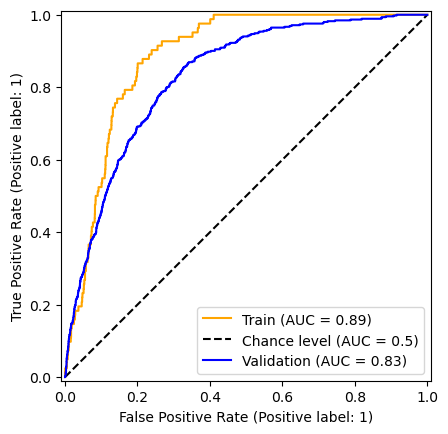

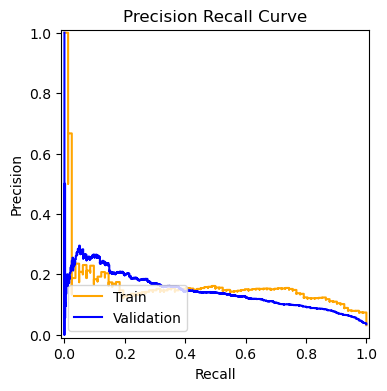

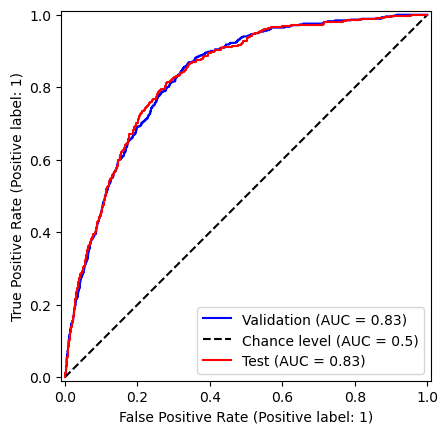

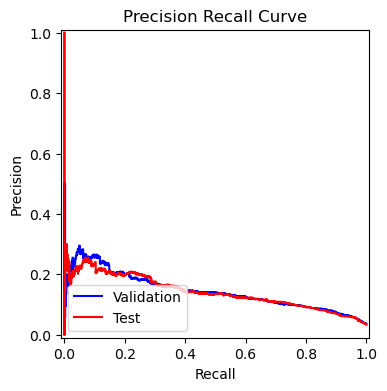

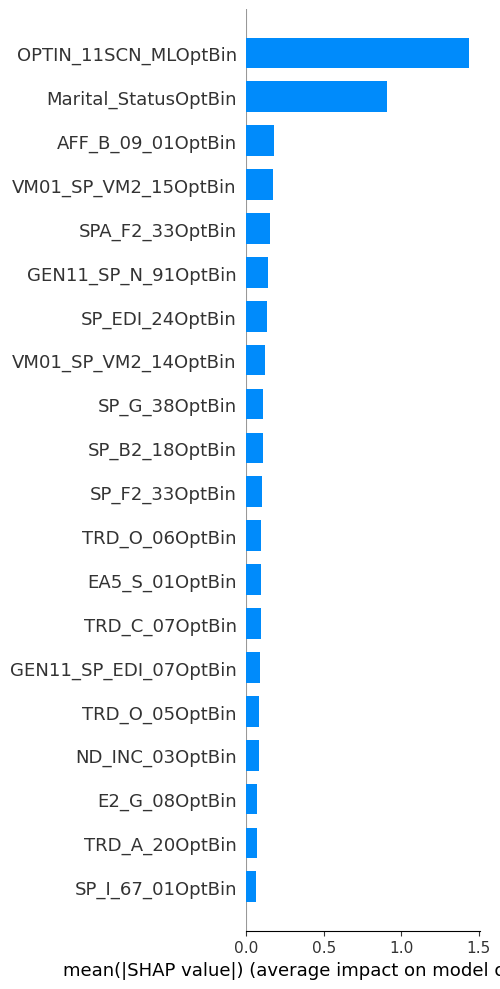

2024/05/27 19:55:07 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/27 19:55:07 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [39]:
with mlflow.start_run(run_name=RUN_NAME, log_system_metrics=True):
    res = search_hyper_params_and_log(
        run_name=RUN_NAME,
        data_dict=data_dict,
        cols_to_use=COLS_TO_USE,
        target_name=TARGET_BIN,
        distributions=PARAMS,
        n_iter=N_ITER,
        model=MODEL,
        custom_params_updates=update_solver_by_penalty,
        tags={'features': len(COLS_TO_USE)}, 
        palette=PALETTE['DataPart'],
        test_name='df_test_same',
        model_path=MODELS_PATH
    )

In [40]:
df_metrics, df_coeff, data_dict, model_obj, std_scaler = res

# Model's quality

## Coefficients

In [41]:
df_coeff.sort_values('Importance(%)', ascending=False)

,Feature,Coeff,Importance(%),p-value,Importance(SHAP),"Importance(SHAP, %)"
16,Intercept,-1.449260,18.118633,0.000000e+00,NaN,NaN
23,OPTIN_11SCN_MLOptBin,-1.110205,13.879780,0.000000e+00,1.436258,28.766927
17,Marital_StatusOptBin,-0.736444,9.207021,0.000000e+00,0.904504,18.116386
14,GEN11_SP_N_91OptBin,-0.227491,2.844096,4.964489e-09,0.136320,2.730357
39,TRD_O_05OptBin,-0.226122,2.826977,1.552092e-13,0.084000,1.682445
27,SP_EDI_24OptBin,-0.216151,2.702316,4.879101e-06,0.135498,2.713905
38,TRD_C_07OptBin,-0.210522,2.631941,1.122086e-06,0.094184,1.886421
10,EA5_S_01OptBin,-0.204145,2.552223,5.351275e-14,0.095571,1.914192
24,SPA_F2_33OptBin,-0.202486,2.531483,2.675054e-07,0.153651,3.077493
40,TRD_O_06OptBin,0.187659,2.346118,2.677898e-10,0.096118,1.925162


In [42]:
# features with 0 coefficients
df_coeff[df_coeff.Coeff == 0]

,Feature,Coeff,Importance(%),p-value,Importance(SHAP),"Importance(SHAP, %)"
49,VM08_SP_VM2_20OptBin,0.0,0.0,1.0,0.0,0.0


In [43]:
# features with high p-value
df_coeff[df_coeff['p-value'] > CONFIDENCE_LEVEL]

,Feature,Coeff,Importance(%),p-value,Importance(SHAP),"Importance(SHAP, %)"
5,E1_B_06OptBin,0.023257,0.290760,0.557078,0.011211,0.224539
7,E4_Q_04OptBin,0.031719,0.396554,0.355586,0.012246,0.245284
9,EA1_D_02OptBin,-0.021399,0.267531,0.346577,0.004571,0.091545
15,GEN11_SP_N_92OptBin,0.009957,0.124477,0.788278,0.007755,0.155334
19,ND_ECC_06OptBin,0.046415,0.580280,0.323185,0.026625,0.533284
25,SP_B1_14OptBin,0.035048,0.438167,0.454064,0.016475,0.329985
28,SP_F2_33OptBin,0.092041,1.150697,0.056907,0.097837,1.959590
29,SP_G_37OptBin,0.056784,0.709912,0.135398,0.041751,0.836235
31,SP_I_63_01OptBin,0.007224,0.090313,0.876105,0.002517,0.050404
33,TRD_A_08OptBin,-0.021210,0.265165,0.553522,0.019837,0.397308


In [44]:
# features with not 0 coefficients
for col in COLS_TO_USE:
    if col not in df_coeff[df_coeff.Coeff == 0].Feature.values:
        print(f'"{col}",')

"OPTIN_11SCN_MLOptBin",
"G5_ND_SPECIIOptBin",
"Marital_StatusOptBin",
"AFF_B_09_01OptBin",
"TRD_A_20OptBin",
"VM01_SP_VM2_15OptBin",
"SP_EDI_24OptBin",
"E4_Q_17OptBin",
"TRD_C_07OptBin",
"SP_B2_18OptBin",
"SPA_F2_33OptBin",
"VM01_SP_VM2_14OptBin",
"SP_G_38OptBin",
"TRD_O_05OptBin",
"E1_A_09OptBin",
"TRD_O_07OptBin",
"ND_INC_03OptBin",
"GEN11_SP_N_91OptBin",
"GEN11_SP_EDI_07OptBin",
"TRD_B_18OptBin",
"EA5_S_01OptBin",
"CLU_CLI_L6M_NPR_L6MOptBin",
"SP_I_67_01OptBin",
"GEN11_SP_K_80OptBin",
"ND_ECC_04OptBin",
"ND_ERL_01OptBin",
"ND_HAC_06OptBin",
"AFF_E_07_01OptBin",
"TRD_O_06OptBin",
"E2_G_08OptBin",
"AFF_T_07_01OptBin",


## GINI, AU PRC

## Test-same

In [45]:
evaluate_model(
    data=data_dict['df_test_same'], 
    cols_to_use=COLS_TO_USE,
    std_scaler=std_scaler,
    target_name=TARGET_BIN,
    model_obj=model_obj
)

Test-PR_AUC 0.14041193335398405
Test-Gini 0.6630439931074468


## Test-full

In [46]:
evaluate_model(
    data=data_dict['df_test'], 
    cols_to_use=COLS_TO_USE,
    std_scaler=std_scaler,
    target_name=TARGET_BIN,
    model_obj=model_obj
)

Test-PR_AUC 0.12131131301108525
Test-Gini 0.6443040427943412


## Outcomes distributions

In [50]:
data_dict['df_test']['score'] = model_obj.predict_proba(
    std_scaler.transform(data_dict['df_test'][COLS_TO_USE])
)[:, 1]

### Test-same

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='score', ylabel='Density'>

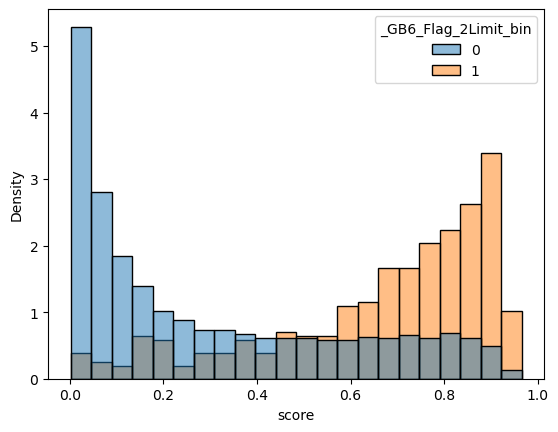

In [51]:
sns.histplot(x=data_dict['df_test_same']['score'], hue=data_dict['df_test_same'][TARGET_BIN], common_norm=False, stat='density')

### Test-full

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='score', ylabel='Density'>

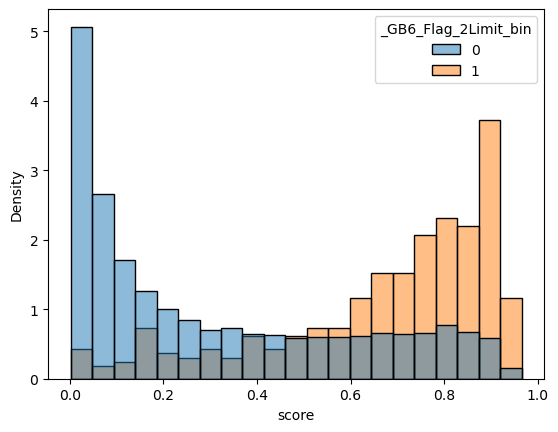

In [52]:
sns.histplot(x=data_dict['df_test']['score'], hue=data_dict['df_test'][TARGET_BIN], common_norm=False, stat='density')

## Precision, Recall By Quantile

### Test-same

In [53]:
m = MetricsByQuantile(metrics=["quantiles_analytics"])
r = m.compute(
    y_true=data_dict['df_test_same'][TARGET_BIN].reset_index(drop=True), 
    y_pred=data_dict['df_test_same']['score'].round(3).reset_index(drop=True), 
    list_of_metrics = [
        "cum_precision_by_quantile", "cum_recall_by_quantile", 
        "precision_by_quantile", "recall_by_quantile",
    ], 
    n_quantiles = 200
)
df_deciles = r["other"]["quantiles_analytics"]
df_deciles.head(50)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,% of total population,Cumulative % of total population,Total,Bad,Cumulative Bad,Quantile,#Quantile,Cumulative Precision,Cumulative Recall,Precision,Recall,Scores
0,0.50,0.50,53,11,11,"(0.927, 0.966]",193,20.754717,3.081232,20.754717,3.081232,0.927--0.966
1,0.51,1.00,54,15,26,"(0.915, 0.927]",192,24.299065,7.282913,27.777778,4.201681,0.915--0.927
2,0.50,1.50,53,11,37,"(0.904, 0.915]",191,23.125000,10.364146,20.754717,3.081232,0.904--0.915
3,0.47,1.97,50,8,45,"(0.897, 0.904]",190,21.428571,12.605042,16.000000,2.240896,0.897--0.904
4,0.50,2.47,53,9,54,"(0.891, 0.897]",189,20.532319,15.126050,16.981132,2.521008,0.891--0.897
5,0.51,2.98,54,10,64,"(0.883, 0.891]",188,20.189274,17.927171,18.518519,2.801120,0.883--0.891
6,0.53,3.50,56,13,77,"(0.875, 0.883]",187,20.643432,21.568627,23.214286,3.641457,0.875--0.883
7,0.50,4.00,53,8,85,"(0.867, 0.875]",186,19.953052,23.809524,15.094340,2.240896,0.867--0.875
8,0.46,4.46,49,8,93,"(0.858, 0.867]",185,19.578947,26.050420,16.326531,2.240896,0.858--0.867
9,0.54,5.01,58,9,102,"(0.852, 0.858]",184,19.136961,28.571429,15.517241,2.521008,0.852--0.858


### Test-full

In [54]:
m = MetricsByQuantile(metrics=["quantiles_analytics"])
r = m.compute(
    y_true=data_dict['df_test'][TARGET_BIN].reset_index(drop=True), 
    y_pred=data_dict['df_test']['score'].round(3).reset_index(drop=True), 
    list_of_metrics = [
        "cum_precision_by_quantile", "cum_recall_by_quantile", 
        "precision_by_quantile", "recall_by_quantile",
    ], 
    n_quantiles = 200
)
df_deciles = r["other"]["quantiles_analytics"]
df_deciles.head(50)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,% of total population,Cumulative % of total population,Total,Bad,Cumulative Bad,Quantile,#Quantile,Cumulative Precision,Cumulative Recall,Precision,Recall,Scores
0,0.50,0.50,57,8,8,"(0.93, 0.966]",193,14.035088,2.240896,14.035088,2.240896,0.93--0.966
1,0.47,0.97,53,14,22,"(0.918, 0.93]",192,20.000000,6.162465,26.415094,3.921569,0.918--0.93
2,0.43,1.41,49,9,31,"(0.908, 0.918]",191,19.496855,8.683473,18.367347,2.521008,0.908--0.918
3,0.53,1.94,60,7,38,"(0.901, 0.908]",190,17.351598,10.644258,11.666667,1.960784,0.901--0.908
4,0.52,2.46,59,11,49,"(0.895, 0.901]",189,17.625899,13.725490,18.644068,3.081232,0.895--0.901
5,0.48,2.94,54,7,56,"(0.888, 0.895]",188,16.867470,15.686275,12.962963,1.960784,0.888--0.895
6,0.52,3.46,59,11,67,"(0.88, 0.888]",187,17.135550,18.767507,18.644068,3.081232,0.88--0.888
7,0.50,3.96,56,12,79,"(0.874, 0.88]",186,17.673378,22.128852,21.428571,3.361345,0.874--0.88
8,0.48,4.43,54,8,87,"(0.866, 0.874]",185,17.365269,24.369748,14.814815,2.240896,0.866--0.874
9,0.50,4.93,56,6,93,"(0.858, 0.866]",184,16.696589,26.050420,10.714286,1.680672,0.858--0.866


Failed to delete temporary folder: C:\Users\hdychko\AppData\Local\Temp\joblib_memmapping_folder_24976_5e55d5d285a546819750616114e0b9ee_9284eeae00c44ccd83ed62abac946bfd
Failed to delete temporary folder: C:\Users\hdychko\AppData\Local\Temp\joblib_memmapping_folder_24976_2b530739764c4e6bb651c3f539a29ac7_a35536a4a45d47e68b6f8816da935ea4
Failed to delete temporary folder: C:\Users\hdychko\AppData\Local\Temp\joblib_memmapping_folder_24976_5e55d5d285a546819750616114e0b9ee_626e2939dbb041f98581ac78c4c93d15
Failed to delete temporary folder: C:\Users\hdychko\AppData\Local\Temp\joblib_memmapping_folder_24976_4a97cd9e81134b27a1bffce6a35a19db_0b4e688776ed4db9aba0095e634a00f1
Failed to delete temporary folder: C:\Users\hdychko\AppData\Local\Temp\joblib_memmapping_folder_24976_5e55d5d285a546819750616114e0b9ee_54b87888006d4de6888ac9db4c7cd043
Failed to delete temporary folder: C:\Users\hdychko\AppData\Local\Temp\joblib_memmapping_folder_24976_3b794919ac6c495990a83f182387c04e_ae2d7210b70f4cb9a14d08d12